# Feature Engineering of Modules Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
ngs_reads = pd.read_json('exported_datasets/prepared_dataset.json')

After exporting/importing to json, dataformat of columns including dataframes is lost, restore to dfs:

In [3]:
for category in ngs_reads:
    if type(ngs_reads[category][0]) is dict:
        ngs_reads[category] = ngs_reads[category].apply(pd.DataFrame)
        print(category, 'converted to DF')

Per base sequence quality converted to DF
Per tile sequence quality converted to DF
Per sequence quality scores converted to DF
Per base sequence content converted to DF
Per sequence GC content converted to DF
Per base N content converted to DF
Sequence Length Distribution converted to DF
Sequence Duplication Levels converted to DF
Overrepresented sequences converted to DF
Adapter Content converted to DF


#### Show example data

In [4]:
ngs_reads.head()

,Per base sequence quality,Per tile sequence quality,Per sequence quality scores,Per base sequence content,Per sequence GC content,Per base N content,Sequence Length Distribution,Sequence Duplication Levels,Overrepresented sequences,Adapter Content,...,module_1_status,module_2_status,module_3_status,module_4_status,module_5_status,module_6_status,module_7_status,module_8_status,module_9_status,module_10_status
0,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 3.0 1 ...,Base G A T ...,GC Content Count 0 0 3.00 ...,Base N-Count 0 1 0.479607 1 ...,Length Count 0 30-39 4192.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,0,2,2,0,2,2,1,2,2,2
1,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 13 2.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.009071 1 ...,Length Count 0 30-39 189.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,1,2,0,2,2,1,2,2,2
2,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 2 1668.0 ...,Base G A T ...,GC Content Count 0 0 1668....,Base N-Count 0 1 0.029292 1 ...,Length Count 0 30-39 4566.0 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,0,1,2,0,1,2,1,1,2,2
3,Base Mean Median Lower Quartile...,Tile Base Mean 0 1101 ...,Quality Count 0 12 2.0 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.0 1 ...,Length Count 0 30-39 8954.0 1 ...,Duplication Level Percentage of deduplicat...,Empty DataFrame Columns: [] Index: [],Position Illumina Universal Adapter Illum...,...,2,2,2,0,2,2,1,1,2,2
4,Base Mean Median Lower Quartile...,Tile Base Mean 0 1102 ...,Quality Count 0 15 3.0 1 ...,Base G A T ...,GC Content Count 0 0 0.0 ...,Base N-Count 0 1 0.0 1 ...,Length Count 0 65-69 1.0 1 70...,Duplication Level Percentage of deduplicat...,...,Position Illumina Universal Adapter Illum...,...,0,0,2,0,0,2,1,2,1,2


### Module 2 - Per tile sequence quality

[Documentation:](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/12%20Per%20Tile%20Sequence%20Quality.html)
>  This graph will only appear in your analysis results if you're using an Illumina library which retains its original sequence identifiers. Encoded in these is the flowcell tile from which each read came. The graph allows you to look at the quality scores from each tile across all of your bases to see if there was a loss in quality associated with only one part of the flowcell.  
The plot shows the deviation from the average quality for each tile. The colours are on a cold to hot scale, with cold colours being positions where the quality was at or above the average for that base in the run, and hotter colours indicate that a tile had worse qualities than other tiles for that base. In the example below you can see that certain tiles show consistently poor quality. A good plot should be blue all over.

![Example Per tile sequence quality](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/per_tile_quality.png)  

Distribution of means, average grouped by tiles - information loss of each base value.

#### Extract features for module 2 based on averages grouped by tiles (with weighting)

In [5]:
# the bases for each tile are grouped inconsistently - the first 9 bases are always ungrouped,
# the following bases are grouped in 5, the last bases are grouped until the end (<5)
# example:
ngs_reads['Per tile sequence quality'][0]
# to calculate the correct mean, weights have to be added to enable calculating the weighted average per tile

,Tile,Base,Mean
0,1101,1,0.030195
1,1101,2,-0.063217
2,1101,3,-0.013447
3,1101,4,0.033154
4,1101,5,0.003146
...,...,...,...
2579,2119,280-284,-0.172432
2580,2119,285-289,-1.815671
2581,2119,290-294,0.908856
2582,2119,295-299,0.152131


In [6]:
def add_weights_tiles(row):
    bases = [int(d) for d in str(row['Base']).split('-')]
    if len(bases) == 1:
        return 1
    elif len(bases) == 2:
        return bases[1]-bases[0]+1

In [7]:
def means_per_tile(dataframe):
    module_2 = dataframe['Per tile sequence quality'] #.copy() - if column weight shouldn't be added to original
    module_2["weight"] = module_2.apply(add_weights_tiles, axis=1)
    weighted_avg = module_2.groupby('Tile').apply(lambda x: np.average(x['Mean'], weights=x['weight']))

    std = np.std(weighted_avg)
    sum_negatives = np.sum(weighted_avg[weighted_avg <0])
    #sum_positives = np.sum(weighted_avg[weighted_avg >= 0])
    #mean_negatives = np.mean((weighted_avg[weighted_avg < 0]), axis=0)
    #mean_positives = np.mean((weighted_avg[weighted_avg >= 0]), axis=0)
    #mean = np.mean(weighted_avg)
    return std, sum_negatives, weighted_avg #, sum_positives, mean_negatives, mean_positives, std, mean

    # tested features show very similar behaviour: std and neg/pos mean have the same characteristics
    # sum_positive and sum_negative mirror each other, mean and sum of all always very close to 0 (why?)
    # leaving sum_negatives in for now, any other characteristics?
    # returning completed weighted averages for data exploration

In [8]:
#ngs_reads[['module_2_std', 'module_2_sum_pos', 'module_2_mean_neg', 'module_2_mean_pos', 'module_2_std', 'module_2_mean'
#          ]] = ngs_reads.apply(create_means_df, axis=1, result_type='expand')

In [9]:
ngs_reads[['module_2_std', 'module_2_sum_neg', 'module_2_weighted_avgs'
          ]] = ngs_reads.apply(means_per_tile, axis=1, result_type='expand')

<AxesSubplot:>

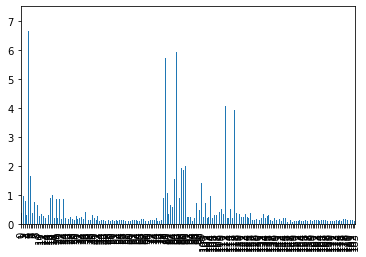

In [10]:
ngs_reads['module_2_std'].plot(kind='bar')

<AxesSubplot:>

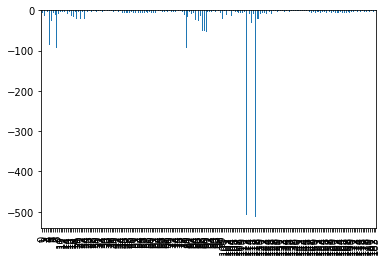

In [11]:
ngs_reads['module_2_sum_neg'].plot(kind='bar')

#### Weighted averages examples

<AxesSubplot:xlabel='Tile'>

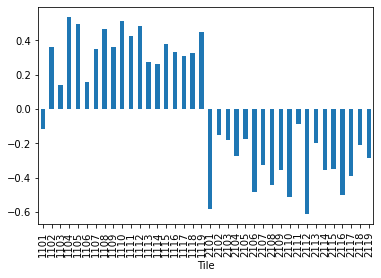

In [12]:
ngs_reads['module_2_weighted_avgs'][0].plot(kind='bar')

<AxesSubplot:xlabel='Tile'>

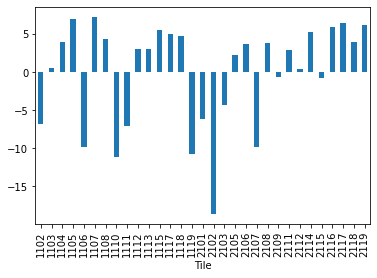

In [13]:
ngs_reads['module_2_weighted_avgs'][4].plot(kind='bar')

<AxesSubplot:ylabel='Frequency'>

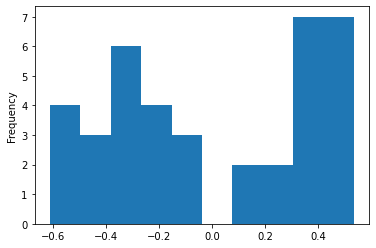

In [14]:
ngs_reads['module_2_weighted_avgs'][0].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

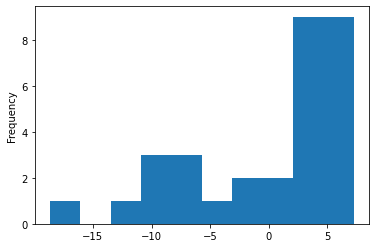

In [15]:
ngs_reads['module_2_weighted_avgs'][4].plot(kind='hist')

In [16]:
ngs_reads.drop(columns='module_2_weighted_avgs', inplace=True) #not a feature